This code has several dependencies.
- Isogeny graph with endomorphism rings: https://github.com/jtcc2/isogeny-database-with-end-rings 
- Constructive Deuring correspondence code: https://github.com/friends-of-quaternions/deuring

In [ ]:
# Import python packages
import os
from tqdm import tqdm
from numpy import argmax

# Import constructive Deuring correspondence code
#    You may need to set the directory in which this can be found with:
#    os.chdir("/home/...")
from deuring.broker import starting_curve
from deuring.correspondence import constructive_deuring, Deuring_Context
from deuring.klpt import KLPT_Context

# Import isogeny database with end rings
load("database_utils.sage")

In [ ]:
def small_equivalent_ideal(I, certificate=False):
    """
    Returns a left-ideal J of smaller norm in the right ideal class.
    If `certificate` is True, also returns the element y such that Iy = J
    """
    _,mn = I.quadratic_form().__pari__().qfminim(None,None,1)
    el = sum(ZZ(c)*g for c,g in zip(mn, I.basis()))
    y = el.conjugate() / I.norm()
    I *= y
    if certificate:
        return I, y
    return I

def all_cornacchia(d, m):
    """
    Returns all solutions to x^2 + dy^2 = m, including imprimitive solutions.
    """
    if m < 0: return []
    if m == 0: return [(0, 0)]
    sols = []
    # Iterate over g such that g^2 divides m
    #   Writing m = q1^e1 * q2^e2 *..., we do this by storing an array [f1, f2, ...] where g = q1^f1 * q2^f2 * ..., and 0 <= fi <= floor(ei / 2)
    #   And we increase it in each iteration [0, 0, 0, ...] -> [1, 0, 0, ...] -> [2, 0, 0, ...] -> (then when f1 is maximum) [0, 1, 0, ...] -> [1, 1, 0, ...] -> ...
    fs = factor(m)
    g_fac_arr = [-1] + [0]*len(fs) # store the exponents of g in this array
    while True:
        g_fac_arr[0] += 1
        g = 1
        for i in range(0, len(fs)):
            if g_fac_arr[i] == floor(fs[i][1]/QQ(2)) + 1: 
                g_fac_arr[i] = 0
                g_fac_arr[i+1] += 1
            # expand value of g
            g *= fs[i][0]**g_fac_arr[i]
        if g_fac_arr[-1] != 0: break
        tempm = ZZ(m/(g**2))
        # Find primitive solutions to x^2 + dy^2 = m/g^2 using Cornacchias and scale them to solution (gx, gy)
        P = PolynomialRing(Integers(tempm), 'X')
        X = P.gens()[0]
        rs =[ZZ(r) for r in (X**2 + d).roots(multiplicities=False)]
        # The above finds solutions r to r^2 = -d  modulo tempm
        #    check if we can add r = tempm, only possible when tempm^2 + d.0^2 = tempm, i.e. tempm^2 = tempm, i.e. tempm = 1
        if tempm == 1:
            rs.append(ZZ(1))
        bound = round(sqrt(tempm),5)
        for r in rs:
            n = tempm
            while r > bound:
                n, r = r, n%r
            s = sqrt((tempm - r**2)/d)
            if s in ZZ:
                sols.extend([(g*r, g*s), (g*r, -g*s), (-g*r, g*s), (-g*r, -g*s)])
                if d == 1:
                    sols.extend([(g*s, g*r), (g*s, -g*r), (-g*s, g*r), (-g*s, -g*r)])
    return list(set(sols))

def Fp_to_int(n):
    """
    Returns element of GF(p) as integer in range (-p/2 ... +p/2]
    """
    if ZZ(n) > n.parent().order() / 2: return ZZ(n) - n.parent().order()
    return ZZ(n)

def find_element_defining_embedding(O, d, t, all_slns=False, filter_func=None):
    """
    Finds an element in quaternion order 'O' with trace 't' and norm 'd'. Set 'all_slns=True' to get all solutions.
        A function can be provided as 'filter_func' which is called when a solution is found to see if it should be counted or not. We use this for filtering primitive solutions.
    """
    slns = [] if all_slns else None
    # Compute the connecting ideal, and find smaller equivalent ideal, to give right order with lower N
    B = O.quaternion_algebra()
    I = B.maximal_order() * O
    J, y = small_equivalent_ideal(I, certificate=True)
    O_new = J.right_order()
    # Put basis in HNF
    basis_hnf = lower_hnf_basis(B, O_new.basis())
    e00, e01, e02, e03 = basis_hnf[0]
    _,   e11, e12, e13 = basis_hnf[1]
    _,   _,   e22, e23 = basis_hnf[2]
    _,   _,   _,   e33 = basis_hnf[3]
    if (e00 == 0) or (e11 == 0) or (e22 == 0) or (e33 == 0):
        return slns
    # Find alpha_0
    alpha_0 = t / (2 * e00)
    if (alpha_0 not in ZZ) or (d not in ZZ):
        return slns
    # Compute a, b, N
    q, p = [ZZ(abs(l)) for l in B.invariants()]
    N = lcm([e.denominator() for e in [e00,e01,e02,e03,e11,e12,e13,e22,e23,e33]])
    N2 = N**2
    # Find residues of alpha_1 mod p
    Fp = GF(p)
    sq_mod_p = Fp(d - (alpha_0 * e00)**2) / Fp(q)
    rt1 = sqrt(sq_mod_p)
    if rt1 not in Fp:
        return slns
    rt2 = -rt1
    residues = [Fp_to_int((rt1 - Fp(alpha_0 * e01)) / Fp(e11)), Fp_to_int((rt2 - Fp(alpha_0 * e01)) / Fp(e11))]
    # compute maximum value of k - for each residue
    temp1 = d - (alpha_0**2)*(e00**2)
    temp1_scaled = N2 * temp1
    temp2 = sqrt(temp1 / q) - alpha_0*e01
    ks = [floor((temp2 - ZZ(r)*e11)/(p*e11)) for r in residues]
    # loop over k decreasing, for each residue
    max_iter = sum([k + 1 for k in ks if k >= 0])
    while max(ks) >= 0:
        k_index = argmax(ks)
        k = ks[k_index]
        r = residues[k_index]
        ks[k_index] = ks[k_index] - 1
        # Compute u and v (v = RHS for Cornacchia)
        alpha_1 = ZZ(r) + k*p
        gamma_1 = alpha_0*e01 + alpha_1*e11
        u = q * N2 * gamma_1**2
        v = ZZ((temp1_scaled - u) / p)
        # find all solutions to Cornacchia's
        betas = all_cornacchia(q, v)
        for beta_pair in betas:
            # Check if this gives a solution with integral alpha_2 and alpha_3
            alpha_2 = (beta_pair[0] - N*alpha_1*e12 - N*alpha_0*e02) / (N*e22)
            alpha_3 = (beta_pair[1] - N*alpha_1*e13 - N*alpha_2*e23 - N*alpha_0*e03) / (N*e33)
            if (alpha_2 in ZZ) and (alpha_3 in ZZ):
                alpha = alpha_0*basis_hnf[0] + alpha_1*basis_hnf[1] + alpha_2*basis_hnf[2] + alpha_3*basis_hnf[3]
                alpha_in_O = y * alpha * y**(-1) # map alpha back in to original order
                valid_sln = True
                if filter_func != None:
                    valid_sln = filter_func(alpha_in_O, k)
                if valid_sln:
                    if all_slns: slns.append(alpha_in_O)
                    if not all_slns: return alpha_in_O
    return slns

def scaled_endomorphism_from_quaternion(elt, i_map, j_map, E, lambdas=False):
    """
    Given an element `elt` in quaternion order corresponding to endomorphism ring of a supersingular elliptic curve `E`,
    returns tuple (map, scalar) where `map` is the endomorphism corresponding to element scalar*elt.

    Requires `i_map` and `j_map` which are tuples (map, scalar) where map is the endomorphism corresponding to scalar*i and scalar*j
    which are elements of the quaternion order containing `elt`.

    If `lambdas` is `True` the map returned will be a python lambda expression rater than a Sage isogeny object.
    These are often more efficient to construct.
    """
    ct = elt.coefficient_tuple()
    ct = [ct[0], ct[1] / i_map[1], ct[2] / j_map[1], ct[3] / (i_map[1]*j_map[1])]
    scalar = lcm([denominator(coeff) for coeff in ct])
    sct = [ZZ(coeff * scalar) for coeff in ct]
    if sct[0] == 0:
        if lambdas:
            scaled_map = lambda P, sct=sct,i_map=i_map,j_map=j_map: sct[1]*i_map[0](P) + sct[2]*j_map[0](P) + sct[3]*i_map[0](j_map[0](P))
        else:
            scaled_map = sct[1]*i_map[0] + sct[2]*j_map[0] + sct[3]*i_map[0]*j_map[0]
    else:
        if lambdas:
            scaled_map = lambda P, sct=sct,i_map=i_map,j_map=j_map: sct[0]*P + sct[1]*i_map[0](P) + sct[2]*j_map[0](P) + sct[3]*i_map[0](j_map[0](P))
        else:
            scaled_map = E.scalar_multiplication(sct[0]) + sct[1]*i_map[0] + sct[2]*j_map[0] + sct[3]*i_map[0]*j_map[0]
    return (scaled_map, scalar)

def quaternion_elements_up_to_automorphism(jinv, O, d, t):
    """
    Given a maximal quaternion order `O` returns list of all quaternion elements defining distinct orientations in `O`.
    That is elements alpha of reduced norm `d` and trace `t` that define different rank 2 ideals in O,  (Z + alpha*Z),
        such that  (Z + alpha*Z)  and  (Z + beta*Z)  are different even when composed with automorphisms,
        i.e for j=1728, (Z + alpha*Z) and (Z + i*alpha*Z) are considered the same orientation.
    Note that conjugates also define the same orientation since  (Z + alpha*Z) = (Z + alpha.conjugate()*Z)
    """
    def minimal_trace_translate(elt):
        """Given a quaternion element `elt`, translate it by an integer to an element of trace 0 or 1."""
        return elt - floor(elt.reduced_trace()/2)
    def get_automorphism_elements(jinv, O):
        """Given a maximal quaternion order `O` corresponding to the endomorphism ring of curves with jiinvariant `jinv`,
        returns the elements within `O` that define automorphisms"""
        if jinv == Fp2(0):
            auto_elt = [a for a in O.unit_ideal().reduced_basis() if a.reduced_norm() == 1 and a != 1 and a != -1][0]
            auto_elt2 = auto_elt^2
            return [1, -1, auto_elt, -auto_elt, auto_elt2, -auto_elt2]
        if jinv == Fp2(1728):
            auto_elt = [a for a in O.unit_ideal().reduced_basis() if a.reduced_norm() == 1 and abs(a.reduced_trace()) == 0][0]
            return [1, -1, auto_elt, -auto_elt] # Typically i and -i, but we can't be certain
        return [1, -1]
    def apply_automorphisms(elt, automorphism_elements):
        """Returns list of minimal trace generators of the rank 2 quaternion ideal Z+elt*Z and other ideals arising from applying automorphisms."""
        elts = []
        for a in automorphism_elements:
            elts += [minimal_trace_translate(a*elt), minimal_trace_translate(elt*a), minimal_trace_translate(-a*elt), minimal_trace_translate(-elt*a)]
        return elts
    # Find all solutions to the Quaternion Embedding Problem
    elts = find_element_defining_embedding(O, d, t, all_slns=True)
    if len(elts) < 2:
        return elts
    # Filter solutions to those which define different orientations
    reps = [elts[0]]
    automorphism_elements = get_automorphism_elements(jinv, O)
    covered = apply_automorphisms(elts[0], automorphism_elements)
    for r in range(1, len(elts)):
        elt = elts[r]
        # Check whether applying an automorphism defines an orientation that already exists
        elt_autos = apply_automorphisms(elt, automorphism_elements)
        arr_check = [(a in covered) or (a.conjugate() in covered) for a in elt_autos]
        if True not in arr_check:
            reps.append(elt)
            covered += elt_autos
    return reps

def smallish_equivalent_ideal(I, bound=2):
    """Given an ideal `I`, find an equivalent ideal of small norm.
    This is intentionally randomized, to return different small ideals with each execution."""
    rb = I.reduced_basis()
    elt = randrange(-bound, bound)*rb[0] + randrange(-bound, bound)*rb[1] + randrange(-bound, bound)*rb[2] + randrange(-bound, bound)*rb[3]
    I2 = I * (elt/I.norm())
    I2 = I2.intersection(I2.left_order()).intersection(I2.right_order())
    return I2

def ideal_to_isogeny(I, O0, E0, E0_i, bound=2, randomize=True):
    """
    Given a quaternion ideal `I` and with a fixed curve `E0` with j-invariant 1728, with it's additional automorphism iota `E0_i`,
    and a fixed maximal order `O0` defining its endomorphism ring, finds an equivalent ideal `J` and corresponding isogeny `phi`
    returning tuple `(phi, J)`. This algorithm is usually refered to as `IdealToIsogeny`.
    
    Requires: https://github.com/friends-of-quaternions/deuring
    """
    KLPT_ctx = KLPT_Context(B)
    first_time = True
    for r in range(0, 50):
        try:
            J = I
            if not first_time:
                J = smallish_equivalent_ideal(I, bound)
            _, facToExt, _, _, _ = KLPT_ctx.KLPT(J)
            dc = Deuring_Context(O0, E0, E0_i, facToExt, None, S=None, f=None, J=None)
            return dc.IdealToIsogeny(I), J
        except:
            first_time = False
            if not randomize:
                break
    raise Exception("Bound too low")

def get_generator_of_quadratic_order(O_quad):
    """Returns generator of a given quadratic order."""
    return upper_hnf_basis(O_quad.number_field(), O_quad.basis())[1]

def connecting_ideal(O0, O1):
    I = O0 * O1
    I = I * denominator(I.norm())
    return I

from sage.all import matrix, QQ, ZZ, lcm, identity_matrix, parent

def basis_to_matrix(basis):
    """
    Given a basis of an ideal as a list, convert it to a column-style basis matrix.
    Assumes all basis elements are of correct type - either QuaternionAlgebra or NumberField.
    """
    B = parent(basis[-1])
    basis_len = len(parent(basis[-1]).basis())
    return matrix(QQ,[[B(basis[m])[r] for r in range(0, basis_len)] for m in range(0, len(basis))]).transpose()

def matrix_to_basis(B, M):
    """
    Given a quaternion algebra B, and a column-style basis matrix M, return the basis as elements of B.
    """
    return [a[0] for a in (M.transpose() * matrix([B(1)] + list(B.gens())).transpose())]

def lower_hnf_matrix(M, transformation=False):
    """
    Reduces matrix to lower triangular form.
    If tranformation=True, also returns matrix T such that M.T is lower HNF.
    """
    denom = lcm([l.denominator() for l in M.list()])
    M_ZZ = matrix(ZZ,[[M[k][l]*denom for l in range(0, M.dimensions()[1])] for k in range(0, M.dimensions()[0])])
    if not transformation:
        return (1/denom) * (M_ZZ.transpose().hermite_form().transpose())
    res1, trans = M_ZZ.transpose().hermite_form(transformation=True)
    return (1/denom) * (res1.transpose()), trans.transpose()

def upper_hnf_matrix(M, transformation=False):
    """
    Reduces matrix to upper triangular form.
    If tranformation=True, also returns matrix T such that M.T is upper HNF.
    """
    if not transformation:
        return lower_hnf_matrix(M[::-1,:])[::-1,::-1]
    res, trans = lower_hnf_matrix(M[::-1,:], True)
    return res[::-1,::-1], trans * identity_matrix(trans.dimensions()[1])[::-1,:]

def lower_hnf_basis(B, basis):
    """
    Reduces basis to lower triangular form.
    """
    return matrix_to_basis(B, lower_hnf_matrix(basis_to_matrix(basis)))

def upper_hnf_basis(B, basis):
    """
    Reduces basis to upper triangular form.
    """
    return matrix_to_basis(B, upper_hnf_matrix(basis_to_matrix(basis)))

In [1045]:
# Step 1 - Set parameters

p = 419
D = 161
f = 1
set_random_seed(0)

L = []
l = 2
while len(L) < 3 and l < 113:
    l = l.next_prime()
    if mod(D, l) == 0:
        continue
    if mod(f, l) == 0:
        continue
    if kronecker(-D, l) == 1:
        L.append(l)
print("INFO: Found suitable primes, L=" + str(L))

print("")
print("INFO: Retrieving Isogeny Graph")
G, jinvs, maxorders = get_isog_graph(p, [2])                     # Full isogeny graph, with list of j-invariants and corresponding maximal quaternion orders
Fp = GF(p)                                                       # Finite fields
Fp2 = parent(jinvs[0])
B = maxorders[0].quaternion_algebra()                            # Quaternion algebra and generators
i,j,k = B.gens()
Q = QuadraticField(-D)                                           # Quadratic field, maximal order, and order of conductor f which we orient by
O_max = Q.ring_of_integers()
O_quad = Q.order_of_conductor(f)
O_quad_gen = get_generator_of_quadratic_order(O_quad)      # Generator of the quadratic order, i.e. omega where order is Z[omega]
d, t = O_quad_gen.norm(), O_quad_gen.trace()                     # Norm and trace of the generator
E0, E0_i, O0 = starting_curve(Fp2)                               # Starting curve with endomorphisms corresponding to i and j
E0_j = E0.frobenius_isogeny()

INFO: Found suitable primes, L=[3, 5, 11]

INFO: Retrieving Isogeny Graph


In [1046]:
# Step 2 - get all oriented curves

class OrientedCurve:
    def __init__(self, E, jinv, maxorder, quaternion_element, scaled_endomorphism_map):
        self.E = E
        self.jinv = jinv
        self.maxorder = maxorder
        self.quaternion_element = quaternion_element
        self.scaled_endomorphism_map = scaled_endomorphism_map

oriented_curves = []
covered_jinvs = []
for idx in tqdm(range(0, len(jinvs))):
    # Make sure we don't do the same endomorphism ring twice (Galois conjugates)
    if jinvs[idx] in covered_jinvs or jinvs[idx]^p in covered_jinvs:
        continue
    covered_jinvs.append(jinvs[idx])
    # Get quaternion elements defining orientations
    O = maxorders[idx]
    elts = quaternion_elements_up_to_automorphism(jinvs[idx], O, d, t)
    if len(elts) == 0:
        continue
    # Get scaled i and j endomorphisms in an isomorphic order
    I = connecting_ideal(O0, O)
    phi, J = ideal_to_isogeny(I, O0, E0, E0_i)
    phidual = phi.dual()
    O_new = J.right_order()
    O_iso = O.isomorphism_to(O_new)
    E = phi.codomain()
    jinv = E.j_invariant()
    scaled_i_map = (phidual.post_compose(E0_i).post_compose(phi), phi.degree())
    scaled_j_map = (phidual.post_compose(E0_j).post_compose(phi), phi.degree())

    for elt in elts:
        elt_new = O_iso(elt)
        # Endomorphism defining orientation
        endo = scaled_endomorphism_from_quaternion(elt_new, scaled_i_map, scaled_j_map, E)
        # Create oriented curves
        oriented_curves.append(OrientedCurve(E, jinv, O_new, elt_new, endo))

    # If this curve is not over Fp, create galois conjugates
    if jinv in Fp:
        continue
    phi, J2 = ideal_to_isogeny(J, O0, E0, -E0_i)
    phidual = phi.dual()
    O_new = J2.right_order()
    O_iso = O.isomorphism_to(O_new)
    E = phi.codomain()
    jinv = jinv^p
    scaled_i_map = (phidual.post_compose(E0_i).post_compose(phi), phi.degree())
    scaled_j_map = (phidual.post_compose(E0_j).post_compose(phi), phi.degree())
    assert(E.j_invariant() == jinv)

    for elt in elts:
        elt_new = O_iso(elt)
        # Endomorphism defining orientation
        endo = scaled_endomorphism_from_quaternion(elt_new, scaled_i_map, scaled_j_map, E)
        # Create oriented curves
        oriented_curves.append(OrientedCurve(E, jinv, O_new, elt_new, endo))

  0%|                                                                                            | 0/36 [00:00<?, ?it/s]/home/james/sagefork2/sage/src/sage/modules/free_module.py:273: UserWarning: You are constructing a free module
over a noncommutative ring. Sage does not have a concept
of left/right and both sided modules, so be careful.
It's also not guaranteed that all multiplications are
done from the right side.
  warn("You are constructing a free module\n"
/home/james/sagefork2/sage/src/sage/modules/free_module.py:1970: UserWarning: You are constructing a free module
over a noncommutative ring. Sage does not have a concept
of left/right and both sided modules, so be careful.
It's also not guaranteed that all multiplications are
done from the right side.
  warn("You are constructing a free module\n"
100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


In [1047]:
# Step 3 - Define group action

from sage.schemes.elliptic_curves.hom_composite import EllipticCurveHom_composite

def class_group_action(oc_idx, l_idx):
    """
    Given an oriented curve and prime l returns a list of the l-oriented neighboring curves.
    Input `oc_idx` is the index such that `oriented_curves[oc_idx]` is the oriented curve to start from.
    Input `l_idx` is the index such that `L[l_idx]` is the prime `l`.
    """

    def automorphisms_nontrivial_up_to_sign(E):
        """Returns automorphisms on a curve `E1` up to sign, excluding the identity map."""
        autos = []
        idm = E.identity_morphism()
        for a in E.automorphisms():
            if a == idm:
                continue
            if a == -idm:
                continue
            if a not in autos and -a not in autos:
                autos.append(a)
        return autos
    def check_scaled_endomorphisms_equal(E, endo1, endo2):
        """
        Given two scaled endomorphisms `endo1` and `endo2` on a curve `E`,
        where each endomorphism is given as a tuple `(map, scalar)` where `map` is an orientation endomorphism scaled by `scalar`,
        returns True if they define the same orientation,
        i.e. if the endomorphisms define the same rank 2 ideals in the endomorphism ring up to composition with an automorphism.
        """
        def maps_equal_up_to_sign(map1, map2, scalar1, scalar2, E):
            """"Given two endomorphisms `map1*scalar1` and `map2*scalar2` on a curve `E`, evaluates them on points to determine if they are the same up to sign."""
            from sage.schemes.elliptic_curves.hom import compare_via_evaluation
            ms1 = map1.post_compose(E.scalar_multiplication(scalar1))
            ms2 = map2.post_compose(E.scalar_multiplication(scalar2))
            if compare_via_evaluation(ms1, ms2):
                return True
            return compare_via_evaluation(ms1, -ms2)
        
        lambda1, d1 = endo1
        lambda2, d2 = endo2
        g = gcd(d1, d2)
        d1_g = ZZ(d1/g)
        d2_g = ZZ(d2/g)

        if maps_equal_up_to_sign(lambda1, lambda2, d2_g, d1_g, E):
            return True
        if t != 0:
            assert(t == 1)
            lambda2_conj = -lambda2 + E.scalar_multiplication(d2)
            if maps_equal_up_to_sign(lambda1, lambda2_conj, d2_g, d1_g, E):
                return True
        additional_automorphisms = automorphisms_nontrivial_up_to_sign(E)

        for r in range(0, len(additional_automorphisms)):
            iota = additional_automorphisms[r]
            lambda2_iota_fp2 = EllipticCurveHom_composite.from_factors([lambda2, iota])
            lambda2_iota_fp2_tr = lambda2_iota_fp2.trace()
            lambda2_iota_R = lambda2_iota_fp2 - E.scalar_multiplication(d2*floor(lambda2_iota_fp2_tr/(2*d2)))
            lambda2_iota_R_conj = -lambda2_iota_R + E.scalar_multiplication(d2)
            if t == mod(lambda2_iota_fp2_tr/d2, 2):
                if maps_equal_up_to_sign(lambda1, lambda2_iota_R, d2_g, d1_g, E):
                    return True
                if t != 0:
                    if maps_equal_up_to_sign(lambda1, lambda2_iota_R_conj, d2_g, d1_g, E):
                        return True
                    
            lambda1_iota_fp2 = EllipticCurveHom_composite.from_factors([lambda1, iota])
            lambda1_iota_fp2_tr = lambda1_iota_fp2.trace()
            lambda1_iota_R = lambda1_iota_fp2 - E.scalar_multiplication(d1*floor(lambda1_iota_fp2_tr/(2*d1)))
            lambda1_iota_R_conj = -lambda1_iota_R + E.scalar_multiplication(d1)
            if t == mod(lambda1_iota_fp2_tr/d1, 2):
                if maps_equal_up_to_sign(lambda1_iota_R, lambda2, d2_g, d1_g, E):
                    return True
                if t != 0:
                    if maps_equal_up_to_sign(lambda1_iota_R_conj, lambda2, d2_g, d1_g, E):
                        return True
            if mod(lambda2_iota_fp2_tr/d2, 2) == mod(lambda1_iota_fp2_tr/d1, 2):
                if maps_equal_up_to_sign(lambda1_iota_R, lambda2_iota_R, d2_g, d1_g, E):
                    return True
                if maps_equal_up_to_sign(lambda1_iota_R_conj, lambda2_iota_R, d2_g, d1_g, E):
                    return True
                if maps_equal_up_to_sign(lambda1_iota_R, lambda2_iota_R_conj, d2_g, d1_g, E):
                    return True
                if maps_equal_up_to_sign(lambda1_iota_R_conj, lambda2_iota_R_conj, d2_g, d1_g, E):
                    return True
        return False

    oc = oriented_curves[oc_idx]
    l = L[l_idx]
    phis = oc.E.isogenies_prime_degree(l)
    codomains = []
    for phi in phis:
        phi_j = phi.codomain().j_invariant()
        possible_codomains = [oc_idx for oc_idx in range(0, len(oriented_curves)) if oriented_curves[oc_idx].jinv == phi_j]
        # Check phi is horizontal
        if len(possible_codomains) == 0:
            continue
        # Apply isomorphism to reach same codomain
        #   Note that all codomain curves in possible_codomains are in fact the same curve as they have the same j invariant
        iso = phi.codomain().isomorphism_to(oriented_curves[possible_codomains[0]].E)
        phi = phi.post_compose(iso)
        phi_dual = phi.dual()
        
        # Compute the orientation on the codomain of phi
        #   Note that the endomorphism ring of the codomain contains the same quaternion element oc.quaternion_element
        #   We do this over the field extension
        codomain_scaled_endomorphism_map = (EllipticCurveHom_composite.from_factors([phi_dual, oc.scaled_endomorphism_map[0], phi]), oc.scaled_endomorphism_map[1]*l)
        
        # Check this endomorphism is the same as the scaled endomorphisms in possible_codomains
        # This checks they define the same orientation, up to automorphisms
        for pc_idx in possible_codomains:
            pc = oriented_curves[pc_idx]
            codomain_curve = phi_dual.domain()
            if check_scaled_endomorphisms_equal(codomain_curve, codomain_scaled_endomorphism_map, pc.scaled_endomorphism_map):
                codomains.append(pc_idx)
    return codomains

In [1048]:
# Step 4 - Build the rim of the oriented isogeny volcano

graph_vertices = [r for r in range(0, len(oriented_curves))]
graph_edges = []

cached_edges = []
for l_idx in range(0, len(L)):
    l = L[l_idx]
    print("")
    print("Evaluating oriented group action for prime " + str(L[l_idx]))
    for r in tqdm(range(0, len(oriented_curves))):
        rs = class_group_action(r, l_idx)
        for r1 in rs:
            # We only add edge to graph_edges when have found both the edge and its dual
            if (r1, r, l) in cached_edges:
                cached_edges.remove((r1, r, l))
                graph_edges.append((r, r1, l))
            else:
                cached_edges.append((r, r1, l))

graph_edges = graph_edges + cached_edges


Evaluating oriented group action for prime 3


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [03:08<00:00, 11.80s/it]



Evaluating oriented group action for prime 5


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:12<00:00,  4.53s/it]



Evaluating oriented group action for prime 11


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:57<00:00,  3.56s/it]


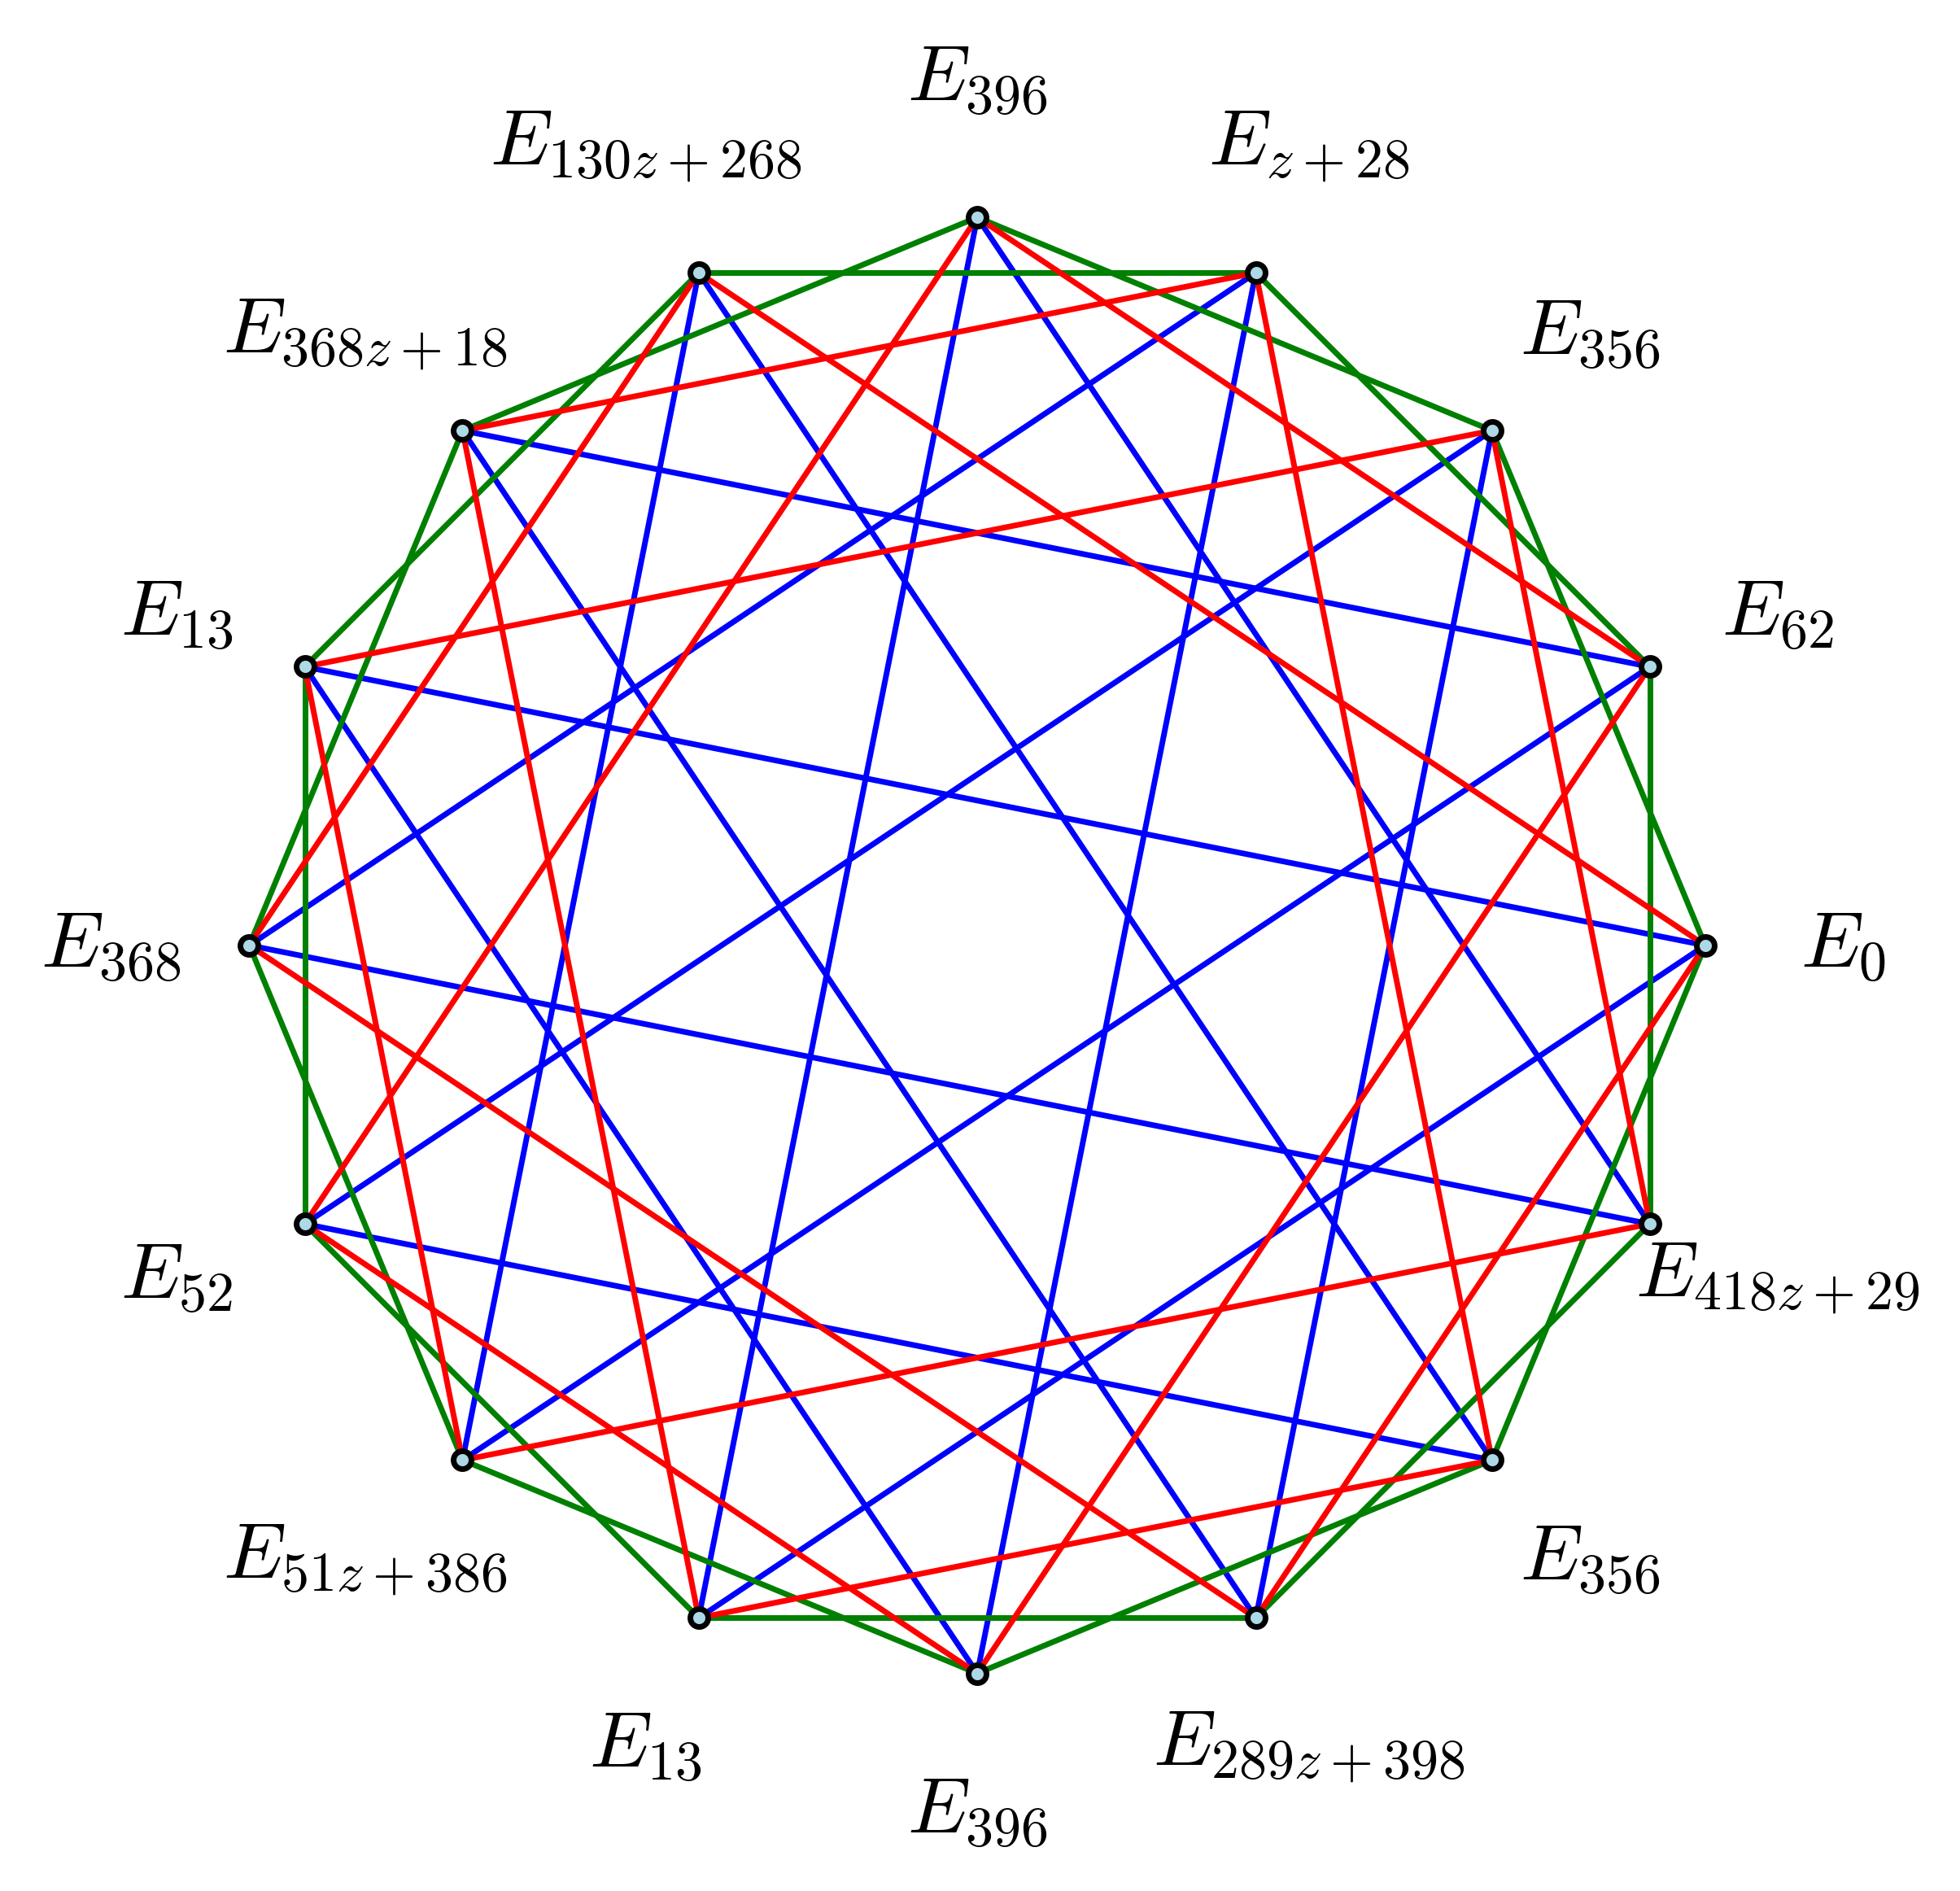

In [1064]:
# Step 5 - Draw the graph
# We attempt to do this in a clever way for each connected component of the graph,
# pick the first l, take the cycles of the l volcano rim and put them into separate lists,
# then order vertices in the connected component by taking one vertex from each cycle, then a second vertex from each cycle,
# gradually moving around all cycles in parallel.

include_edges = L   # Use this to filter edges

def colors_from_L(L):
    L_copy = copy(L)
    while len(L_copy) < 3:
        L_copy.append(0)
    return {L_copy[0]: "blue", L_copy[1]: "green", L_copy[2]: "red"}

def order_cycle_vertices(G, v):
    arr = [v]
    cur_v = v
    while True:
        nbs = G.neighbors(cur_v)
        valid_nbs = [v for v in nbs if v not in arr]
        if len(valid_nbs) == 0:
            break
        cur_v = valid_nbs[0]
        arr.append(cur_v)
    return arr

def interchange_order(lists, offsets=None):
    arr = []
    total_len = sum([len(arr) for arr in lists])
    idx1 = 0
    idx2 = 0
    while len(arr) < total_len:
        if offsets == None:
            arr.append(lists[idx1][idx2])
        else:
            arr.append(lists[idx1][mod(idx2 + offsets[idx1], len(lists[idx1]))])
        idx1 += 1
        if idx1 == len(lists):
            idx1 = 0
            idx2 += 1
    return arr

def circle_plot(G, vertex_order):
    textratio = 1.19
    yoffset = 0.03
    G = G.subgraph(vertex_order)
    angle_per_vertex = (2*pi) / len(vertex_order)
    pos = {k: [float(cos(vertex_order.index(k)*angle_per_vertex)), float(sin(vertex_order.index(k)*angle_per_vertex))] for k in G.vertices()}
    plot = G.graphplot(vertex_color="lightblue", edge_colors=G._color_by_label(colors_from_L(L)), vertex_size=10, vertex_labels=False, pos=pos)
    textobj = [text("$E_{" + str(oriented_curves[k].jinv).replace("*", "") + "}$", (float(textratio*cos(vertex_order.index(k)*angle_per_vertex)), float(textratio*sin(vertex_order.index(k)*angle_per_vertex))), axes=False, color="black", fontsize=14)   for k in G.vertices()]
    # textobj += [text("$" + str(oriented_curves[k].quaternion_element).replace("*", "") + "$", (float(textratio*cos(vertex_order.index(k)*angle_per_vertex)), -yoffset + float(textratio*sin(vertex_order.index(k)*angle_per_vertex))), axes=False, color="black", fontsize=8)   for k in G.vertices()]
    return plot, sum(textobj)

# Use the second prime here as the result looks better
l1 = include_edges[1]

G = Graph([graph_vertices, [e for e in graph_edges if e[2] in include_edges]], loops = True, multiedges=True)
for CC in G.connected_components():
    CC_vs = [v for v in graph_vertices if v in CC]
    CC_es = [e for e in graph_edges if e[0] in CC]
    G2 = Graph([CC_vs, CC_es], loops = True, multiedges=True)
    G2_l1 = Graph([
        CC_vs,
        [e for e in CC_es if e[2] == l1]
        ], loops = True, multiedges=True)
    arrs = [order_cycle_vertices(G2_l1, G2_CC[0]) for G2_CC in G2_l1.connected_components()]
    
    # We change the offsets here to make it look better
    v_ordered = interchange_order(arrs, [0, 5])

    # Alternatively do
    # v_ordered = interchange_order(arrs)

    r1, r2 = circle_plot(G2, v_ordered)
    (r1.plot() + r2).show(transparent=True, dpi=500)